# Example of sampling: Visualize parameter samples in phenotype when allowing two varying parameters

In [1]:
%load_ext autoreload
%autoreload 2

import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

import os
import math
import scipy
from scipy.integrate import odeint
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', -1)
import ast
from time import time
import re
from random import shuffle

from importlib import import_module

import dspace
import dspace.plotutils

from utils import int_model, draw_single_pheno_samples, check_oscillation, \
                    process_check_plot_pset, count_parameter_occurence, merge_two_dicts, \
                    random_sample_phenotype, draw_time_course, build_analyse_design_space, load_model_variables

print 'System information:'
print 'dspace            ' + dspace.__version__
print 'libdesignspace    ' + dspace.__c_toolbox__.__version__
print 'matplotlib        ' + matplotlib.__version__
print 'numpy             ' + np.__version__
print 'sciPy             ' + scipy.__version__

System information:
dspace            0.3.0a4
libdesignspace    0.3.0a6
matplotlib        2.2.2
numpy             1.14.1
sciPy             1.1.0


# Using the oscillatory phenotype from (Lomnitz et al., 2015)

In [2]:
modelID = 'lomnitz2015'
num_samples = 300

### load required variables ###
scipy_model, pset, variables, y0, f, constraints, parbounds, latex_symbols, varnames = load_model_variables(modelID)

### build design space and save characteristics ###
ds, valid_cases = build_analyse_design_space(modelID, f, constraints, latex_symbols)

{'a1': [3.1591153825082117, 3.165439937828548], 'rho3': [99.9, 100.1], 'rho1': [99.9, 100.1], 'K4': [0.03159115382508213, 0.03165439937828549], 'b4': [0.09999999999999995, 9.999999999999995], 'K2R': [0.999, 1.001], 'a3': [0.999, 1.001], 'a2': [0.999, 1.001], 'b1': [0.999, 1.001], 'b2': [0.031622776601683826, 10.0], 'b3': [0.999, 1.001], 'K2A': [0.31591153825082113, 0.3165439937828548], 'a4': [0.999, 1.001]}


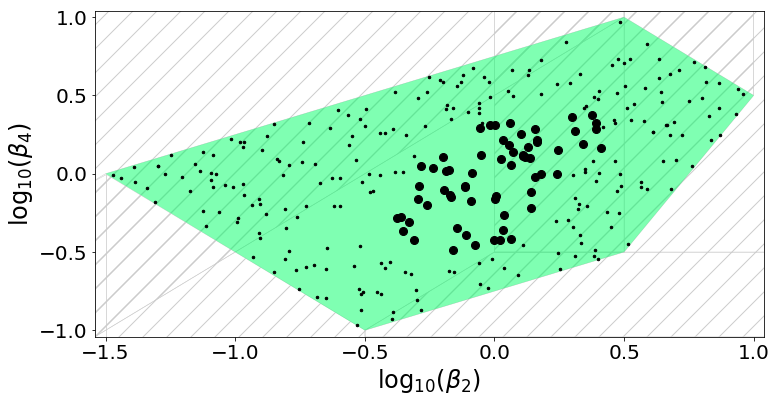

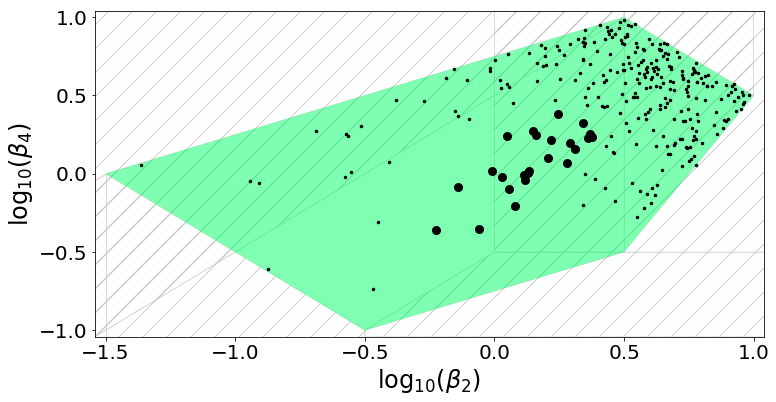

In [39]:
pheno_str = '23'
pheno = ds(pheno_str)

pvals = pheno.valid_parameter_set()
pvals_orig = pvals.copy()

# Visualize this pheno in terms of two parameters
sorted_pars = pvals.keys()
shuffle(sorted_pars)
x_par = sorted_pars[0]
y_par = sorted_pars[1]

x_par = 'b2'
y_par = 'b4'

# determine vertices for slice parameters
vert = pheno.vertices_2D_slice(pvals,x_par,y_par)
vert_x = [x[0] for x in pheno.vertices_2D_slice(pvals,x_par,y_par)]
vert_y = [x[1] for x in pheno.vertices_2D_slice(pvals,x_par,y_par)]
range_x = [max(1e-3,min(vert_x)), min(1e3,max(vert_x))]
range_y = [max(1e-3,min(vert_y)), min(1e3,max(vert_y))]

# zoom out slightly further for the visuals
multiplier = 1.1
range_x_vis = [range_x[0]/multiplier, range_x[1]*multiplier]
range_y_vis = [range_y[0]/multiplier, range_y[1]*multiplier]

# find phenotype samples 
parbounds = {p: [0.999*pvals[p], 1.001*pvals[p]] for p in pvals}
parbounds[x_par] = range_x
parbounds[y_par] = range_y
print parbounds

# generate random samples
colnames = ['n','Method','Parameters','IC','Peak sequence','Period','Min. Amplitude (min/max)']
df_samples_logunif = pd.DataFrame(columns=colnames)
df_samples_unif = pd.DataFrame(columns=colnames)
for i_iter in range(num_samples):
    # sample
    sample_logunif, IC_logunif = random_sample_phenotype(pheno,parbounds,loguniform=True)
    sample_unif, IC_unif = random_sample_phenotype(pheno,parbounds,loguniform=False)

    # Calculate time course and check for oscillation
    # logunif
    oscillates, t, x, initial_conditions, peak_props = check_oscillation(scipy_model,sample_logunif,IC_logunif,ds)
    if oscillates:
        LC_series = pd.Series({'Oscillates':True,'Parameters':sample_logunif,'IC':IC_logunif,'Peak sequence':peak_props['peak sequence'],
                            'Period':peak_props['period'],
                            'Min. Amplitude (min/max)':peak_props['Min. Amplitude (min/max)'] },name=i_iter)
    else:
        LC_series = pd.Series({'Oscillates':False,'Parameters':sample_logunif,'IC':IC_logunif },name=i_iter)
    df_samples_logunif = df_samples_logunif.append(LC_series)
    
    # unif
    oscillates, t, x, initial_conditions, peak_props = check_oscillation(scipy_model,sample_unif,IC_unif,ds)
    if oscillates:
        LC_series = pd.Series({'Oscillates':True,'Parameters':sample_unif,'IC':IC_unif,'Peak sequence':peak_props['peak sequence'],
                            'Period':peak_props['period'],
                            'Min. Amplitude (min/max)':peak_props['Min. Amplitude (min/max)'] },name=i_iter)
    else:
        LC_series = pd.Series({'Oscillates':False,'Parameters':sample_unif,'IC':IC_unif },name=i_iter)
    df_samples_unif = df_samples_unif.append(LC_series)
    
# visualize
fig = draw_single_pheno_samples(ds, pheno_str, pvals_orig, x_par, y_par, range_x_vis, range_y_vis, df_samples_logunif)
fig.savefig('../Figures/Example_parameter_sampling_Lomnitz2015_23_loguniform.png', dpi=300, bbox_inches='tight')

fig = draw_single_pheno_samples(ds, pheno_str, pvals_orig, x_par, y_par, range_x_vis, range_y_vis, df_samples_unif)
fig.savefig('../Figures/Example_parameter_sampling_Lomnitz2015_23_uniform.png', dpi=300, bbox_inches='tight')